# Advection of a Gaussian profile on an interval

$$
\mathbb{S}
\begin{cases}
\Omega = [0, L_x] \\
u_0(x)=\exp\left(-\frac{(x - x_0)^2}{\sigma^2}\right) \\
u_{\text{I}}(x=0) = 1 \\
\textbf{a}(t)=(1 + \epsilon\sqrt{t})\textbf{e}_x \\
\end{cases}
$$

In [ ]:
import numpy as np
from lucifex.mesh import interval_mesh
from lucifex.fem import Constant
from lucifex.fdm import (
    FiniteDifference, FiniteDifferenceArgwise, FunctionSeries, ConstantSeries, 
    BE, FE, CN, finite_difference_order, cfl_timestep,
)
from lucifex.solver import ibvp, evaluation , BoundaryConditions
from lucifex.sim import Simulation, run
from lucifex.viz import plot_line
from lucifex.io import write, get_ipynb_file_name
from lucifex.utils import nested_dict
from lucifex.pde.advection import advection


def velocity(
    t: Constant | float,
    eps: float,
) -> tuple[float]:
    return (1.0 + eps * np.sqrt(float(t)), )


def create_simulation(
    Lx: float,
    Nx: int,
    dt: float,
    D_adv: FiniteDifference | FiniteDifferenceArgwise,
    x0: float,
    sigma: float,
    eps: float,
) -> Simulation:
    order = finite_difference_order(D_adv)
    mesh = interval_mesh(Lx, Nx)
    t = ConstantSeries(mesh, name='t', ics=0.0)
    dt = Constant(mesh, dt, name='dt')
    a = ConstantSeries(mesh, name='a', order=order, shape=(1,), store=1, ics=velocity(0.0, eps))
    a_solver = evaluation(a, velocity, future=True)(t[1], eps)
    u = FunctionSeries((mesh, 'P', 1), name='u', order=order, store=1)
    u_ics = lambda x: np.exp(-(x[0] - x0)**2 / sigma**2)
    u_bcs = BoundaryConditions(('dirichlet', lambda x: x[0], 0.0))
    u_solver = ibvp(advection, u_ics, u_bcs)(u, dt, a, D_adv)
    solvers = [a_solver, u_solver]
    return Simulation(solvers, t, dt)


Lx = 1.0
Nx = 250
x0 = 0.2 * Lx
sigma = 0.001 ** 0.5
eps = 0.01

dt_opts = (0.005, 0.001)
D_adv_opts = (FE, BE, FE @ BE, CN)
simulations = nested_dict((float, FiniteDifference, Simulation))

for dt in dt_opts:
    for D_adv in D_adv_opts:
        simulations[dt][D_adv] = create_simulation(Lx, Nx, dt, D_adv, x0, sigma, eps)

t_stop = 1.0
n_stop = 200
for dt in dt_opts:
    for D_adv in D_adv_opts:
        run(simulations[dt][D_adv], n_stop, t_stop) 

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$t$', ylabel='$a(t)$'>)

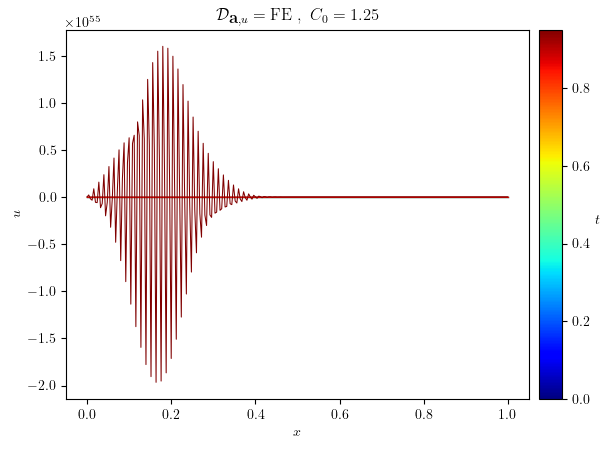

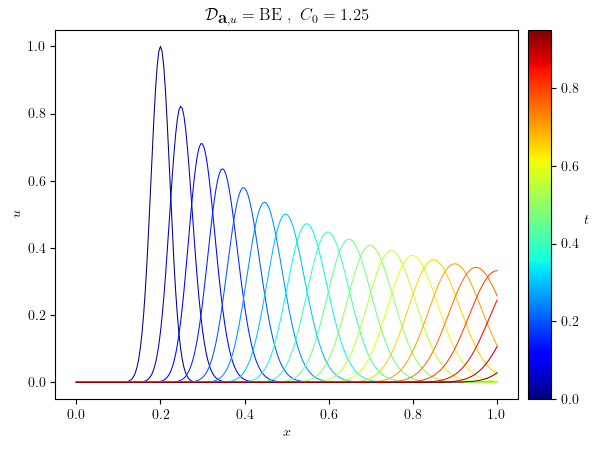

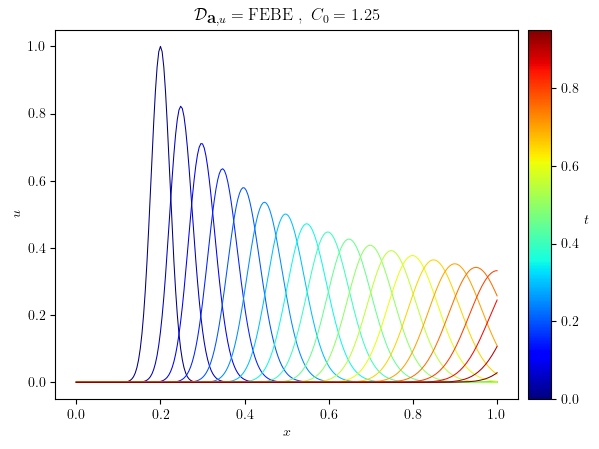

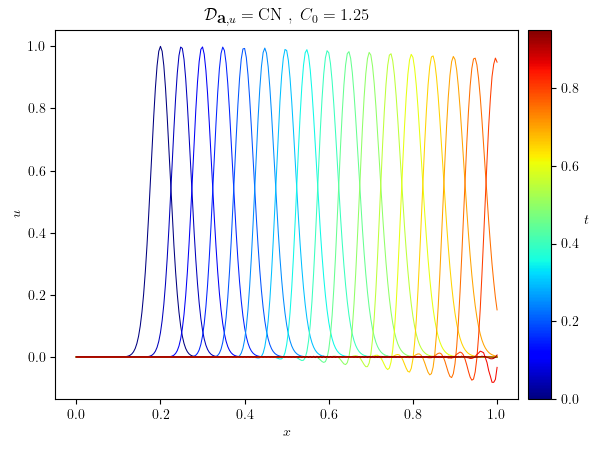

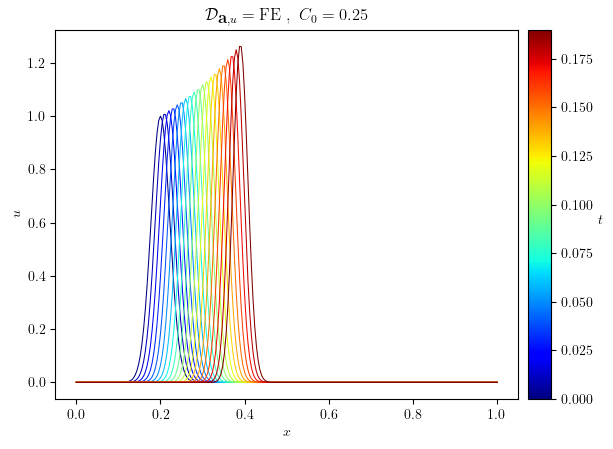

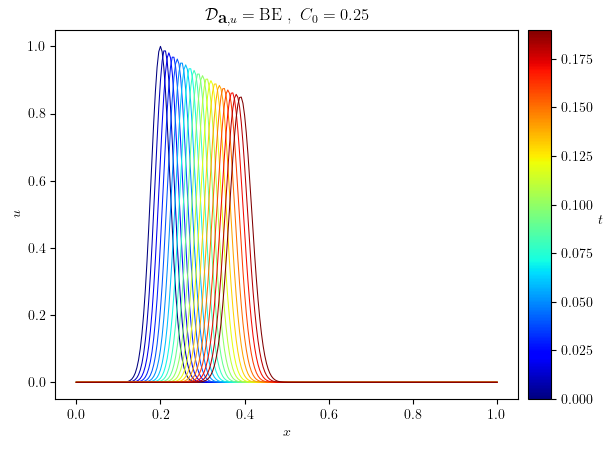

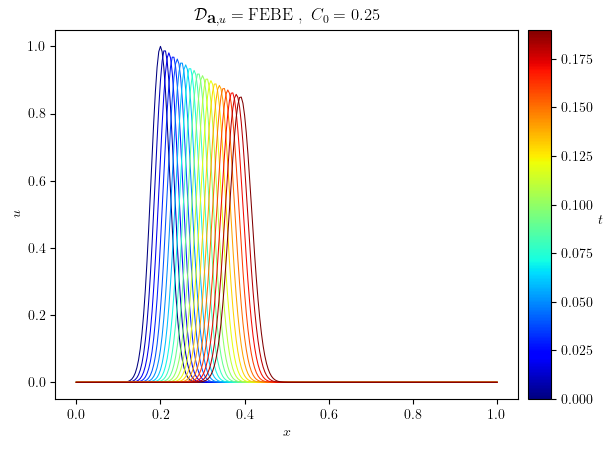

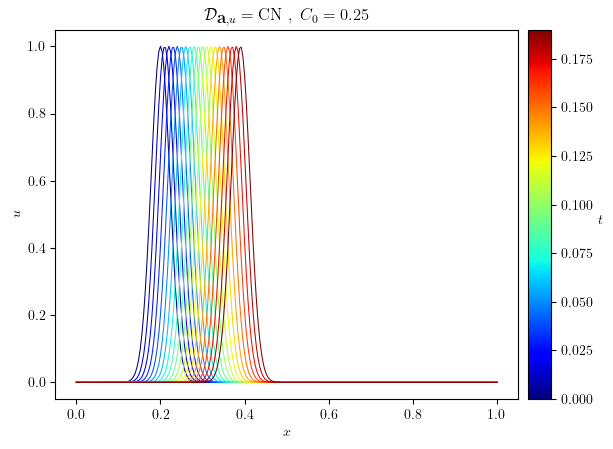

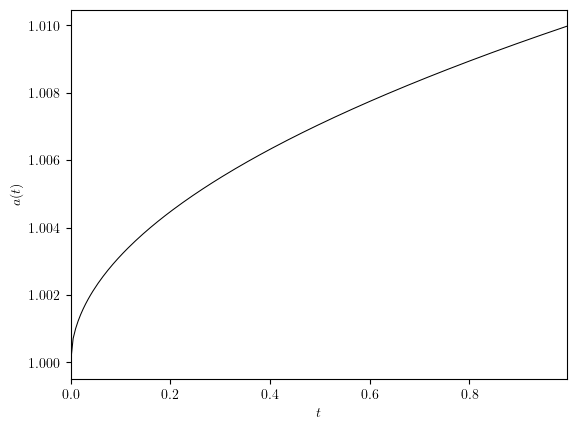

: 

In [ ]:
time_slice = slice(0, None, 10)

for dt in dt_opts:
    h = Lx/ Nx
    dt_courant_init = cfl_timestep(velocity(0.0, eps), h)
    courant_init = dt / dt_courant_init
    for D_adv in D_adv_opts:
        u = simulations[dt][D_adv]['u']
        legend_labels=(min(u.time_series[time_slice]), max(u.time_series[time_slice]))
        title = f"$\mathcal{{D}}_{{\\textbf{{a}}, u}}=\\mathrm{{{str(D_adv)}}}~,~C_0={courant_init}$"
        fig, ax = plot_line(
            u.series[time_slice], 
            legend_labels, '$t$', cyc='jet', x_label='$x$', y_label='$u$', title=title)
        write(fig, f'{get_ipynb_file_name()}_{D_adv}', './figures', close=False, pickle=False)

a = simulations[dt_opts[0]][D_adv_opts[0]]['a']
a_scalar = [i[0] for i in a.value_series]
plot_line((a.time_series, a_scalar), x_label='$t$', y_label=f'${a.name}(t)$')